# Импорт библиотек

In [1]:
import numpy as np
import os, warnings
import matplotlib.pyplot as plt
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Изучение данных

In [2]:
import pathlib

train_dir = pathlib.Path("/Users/ivan/DS_educate/CNN/FastFoodClassification/Train")
valid_dir = pathlib.Path("/Users/ivan/DS_educate/CNN/FastFoodClassification/Valid")
test_dir = pathlib.Path("/Users/ivan/DS_educate/CNN/FastFoodClassification/Test")

## сколько файлов в директориях?

In [3]:
de_train = list(train_dir.glob('*/*.*'))
de_valid = list(valid_dir.glob('*/*.*'))
de_test = list(test_dir.glob('*/*.*'))

print(f"Total images in train set\t: {len(de_train)}")
print(f"Total images in valid set\t: {len(de_valid)}")
print(f"Total images in testing set\t: {len(de_test)}")

Total images in train set	: 15000
Total images in valid set	: 3500
Total images in testing set	: 1500


## Как выглядит?

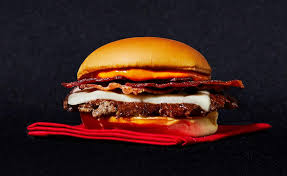

In [4]:
burgers = list(train_dir.glob("Burger/*"))
PIL.Image.open(str(burgers[228]))

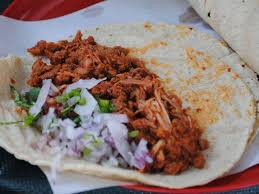

In [5]:
tacos = list(train_dir.glob("Taco/*"))
PIL.Image.open(str(tacos[228]))

# Загрузка набора данных

## Определяю параметры

In [6]:
batch_size = 300
width = 180
height = 180
color_mode = 'rgb'

## Выберу файлы только с форматом jpeg

In [7]:
train_files = tf.data.Dataset.list_files(str(train_dir/'*/*.jpeg'), shuffle=True)
valid_files = tf.data.Dataset.list_files(str(valid_dir/'*/*.jpeg'), shuffle=False)
test_files = tf.data.Dataset.list_files(str(test_dir/'*/*.jpeg'), shuffle=False)

print(f"Number of training data files {len(list(train_files))}")
print(f"Number of validation data files {len(list(valid_files))}")
print(f"Number of testing data files {len(list(test_files))}")

Number of training data files 14778
Number of validation data files 3500
Number of testing data files 1497


### Какие классы?

In [8]:
class_names = np.array(sorted([item.name for item in train_dir.glob('*')]))
class_names

array(['.DS_Store', 'Baked Potato', 'Burger', 'Crispy Chicken', 'Donut',
       'Fries', 'Hot Dog', 'Pizza', 'Sandwich', 'Taco', 'Taquito'],
      dtype='<U14')

# Преобразую пути файлов в (image, label)

In [9]:
def get_label(filepath):
    # Преобразование пути в список компонентов пути
    parts = tf.strings.split(filepath, os.path.sep)
    # Предпоследним является каталог классов
    one_hot = parts[-2] == class_names
    # Целочисленное кодирование метки
    return tf.argmax(one_hot)

def decode_img(img):
    # Преобразование сжатой строки в 3D uint tensor
    img = tf.io.decode_jpeg(img, channels=3)
    # Изменение размера картинки в нужное
    return tf.image.resize(img, [height, width])

def process_path(filepath):
    label = get_label(filepath)
    
    # Загрузить необработанные данные из файла в виде строки
    img = tf.io.read_file(filepath)
    img = decode_img(img)
    return img, label

# Конфигурация датасета

In [10]:
# Сопоставление (маппинг) датасета из файлов
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_files.map(process_path, num_parallel_calls=AUTOTUNE)
valid_dataset = valid_files.map(process_path, num_parallel_calls=AUTOTUNE)
test_dataset = test_files.map(process_path, num_parallel_calls=AUTOTUNE)


def configure_for_performance(dataset, size):
    dataset = dataset.cache()
    dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(batch_size=size)
    return dataset.prefetch(buffer_size=AUTOTUNE)

train_dataset = configure_for_performance(train_dataset, batch_size * 3)
valid_dataset = configure_for_performance(valid_dataset, batch_size)
test_dataset = configure_for_performance(test_dataset, batch_size)

# Слой нормализации

In [11]:
# Get input shape
input_shape = [height, width, 3]
print(input_shape)
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255, input_shape=input_shape)
num_class = len(class_names)

[180, 180, 3]


# Определение модели

In [12]:
model = keras.Sequential([
    normalization_layer,
    
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Flatten(),
    
    layers.Dense(128, activation='relu'),
    layers.Dense(num_class)
])

In [13]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)
# хочу оценивать по accuracy

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

# Обучение модели

In [15]:
epochs = 20
history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=epochs
)

Epoch 1/20


2023-05-08 22:09:52.623832: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


17/17 [==============================] - 69s 4s/step - loss: 2.5102 - accuracy: 0.1040 - val_loss: 2.2943 - val_accuracy: 0.1414
Epoch 2/20
17/17 [==============================] - 87s 5s/step - loss: 2.2288 - accuracy: 0.1752 - val_loss: 2.1980 - val_accuracy: 0.2026
Epoch 3/20
17/17 [==============================] - 88s 5s/step - loss: 2.1196 - accuracy: 0.2356 - val_loss: 2.1339 - val_accuracy: 0.2480
Epoch 4/20
17/17 [==============================] - 86s 5s/step - loss: 2.0221 - accuracy: 0.2811 - val_loss: 2.0229 - val_accuracy: 0.2911
Epoch 5/20
17/17 [==============================] - 87s 5s/step - loss: 1.9203 - accuracy: 0.3369 - val_loss: 1.9004 - val_accuracy: 0.3563
Epoch 6/20
17/17 [==============================] - 87s 5s/step - loss: 1.8490 - accuracy: 0.3680 - val_loss: 1.8542 - val_accuracy: 0.3889
Epoch 7/20
17/17 [==============================] - 86s 5s/step - loss: 1.7255 - accuracy: 0.4192 - val_loss: 1.8072 - val_accuracy: 0.3854
Epoch 8/20
17/17 [=============

# Результаты обучения

In [19]:
import pandas as pd 

In [20]:
history_df = pd.DataFrame(history.history)
history_df

,loss,accuracy,val_loss,val_accuracy
0,2.510168,0.104006,2.294305,0.141429
1,2.228769,0.175193,2.198027,0.202571
2,2.119633,0.235553,2.133865,0.248000
3,2.022133,0.281094,2.022908,0.291143
4,1.920252,0.336920,1.900449,0.356286
5,1.849000,0.368047,1.854207,0.388857
6,1.725453,0.419204,1.807190,0.385429
7,1.663267,0.441602,1.817988,0.386857
8,1.577406,0.470700,1.742254,0.404857
9,1.500719,0.503925,1.740055,0.412000


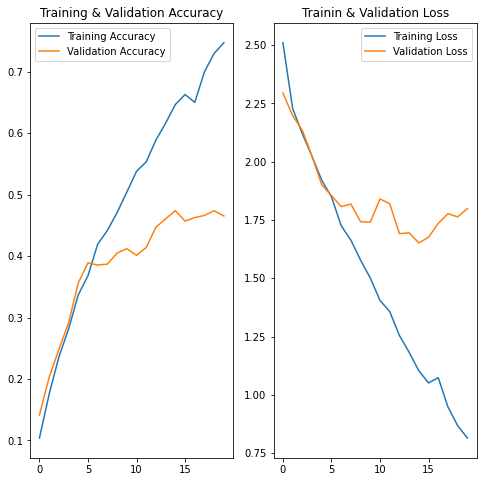

In [21]:
plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)
plt.plot(range(epochs), history_df['accuracy'], label='Training Accuracy')
plt.plot(range(epochs), history_df['val_accuracy'], label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(epochs), history_df['loss'], label='Training Loss')
plt.plot(range(epochs), history_df['val_loss'], label='Validation Loss')
plt.title('Trainin & Validation Loss')
plt.legend()

plt.show()

### кажется, что эпох можно было бы дать и меньше, но меня устроит такой скор

## Сохраню модель в формате pickle

In [142]:
import pickle

filename = 'cnn_model_FoodRecognition.sav'
pickle.dump(model, open(filename, 'wb'))

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......flatten
.........vars
......max_pooling2d
.........vars
......max_pooling2d_1
.........vars
......max_pooling2d_2
.........vars
......rescaling
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
.........17
.........18
.........19
.........2
.........20
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                                      

# Проверка результатов обучения модели на тестовых данных 

In [116]:
def convert_toarray(testing_food, num):
    path = str(testing_food[num])
    img = tf.keras.utils.load_img(
    path, target_size=[height, width])
    
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    round_score = round(100 * np.max(score),2)
    pred_class = class_names[np.argmax(score)]
                             
    return f"На картинке вероятно {pred_class} с уверенностью {round_score}%)"

1/1 [==============================] - 0s 16ms/step
На картинке вероятно Burger с уверенностью 98.66%)


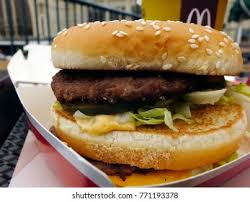

In [117]:
food = "Burger"
num = 22

testing_food = list(test_dir.glob(f"{food}/*"))

print(convert_toarray(testing_food, num))
PIL.Image.open(testing_food[num])

1/1 [==============================] - 0s 15ms/step
На картинке вероятно Taco с уверенностью 98.59%)


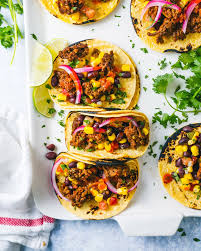

In [118]:
food = "Taco"
num = 60

testing_food = list(test_dir.glob(f"{food}/*"))

print(convert_toarray(testing_food, num))
PIL.Image.open(testing_food[num])

1/1 [==============================] - 0s 14ms/step
На картинке вероятно Burger с уверенностью 92.35%)


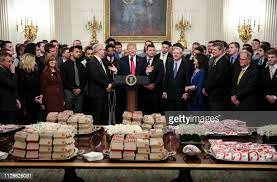

In [119]:
food = "Burger"
num = 20

testing_food = list(test_dir.glob(f"{food}/*"))

print(convert_toarray(testing_food, num))
PIL.Image.open(testing_food[num])

1/1 [==============================] - 0s 16ms/step
На картинке вероятно Taquito с уверенностью 27.34%)


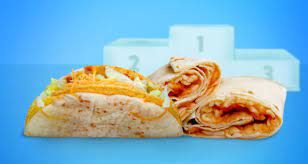

In [131]:
food = "Taquito"
num = 31

testing_food = list(test_dir.glob(f"{food}/*"))

print(convert_toarray(testing_food, num))
PIL.Image.open(testing_food[num])

1/1 [==============================] - 0s 13ms/step
На картинке вероятно Taco с уверенностью 72.24%)


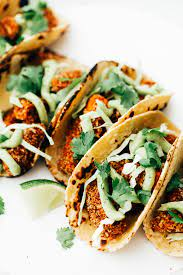

In [132]:
food = "Taco"
num = 25

testing_food = list(test_dir.glob(f"{food}/*"))

print(convert_toarray(testing_food, num))
PIL.Image.open(testing_food[num])

1/1 [==============================] - 0s 14ms/step
На картинке вероятно Pizza с уверенностью 96.64%)


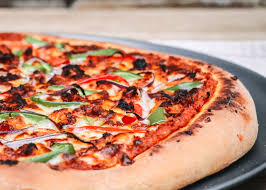

In [134]:
food = "Pizza"
num = 95

testing_food = list(test_dir.glob(f"{food}/*"))

print(convert_toarray(testing_food, num))
PIL.Image.open(testing_food[num])

1/1 [==============================] - 0s 17ms/step
На картинке вероятно Baked Potato с уверенностью 94.35%)


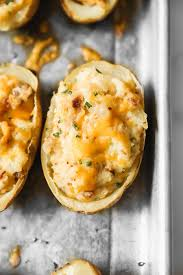

In [136]:
food = "Baked Potato"
num = 20

testing_food = list(test_dir.glob(f"{food}/*"))

print(convert_toarray(testing_food, num))
PIL.Image.open(testing_food[num])

1/1 [==============================] - 0s 15ms/step
На картинке вероятно Donut с уверенностью 93.53%)


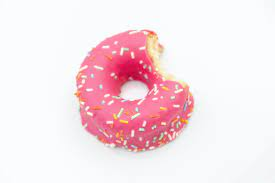

In [137]:
food = "Donut"
num = 20

testing_food = list(test_dir.glob(f"{food}/*"))

print(convert_toarray(testing_food, num))
PIL.Image.open(testing_food[num])

1/1 [==============================] - 0s 15ms/step
На картинке вероятно Hot Dog с уверенностью 73.25%)


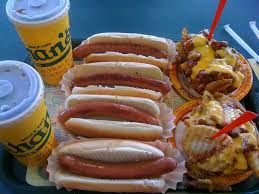

In [141]:
food = "Hot Dog"
num = 66

testing_food = list(test_dir.glob(f"{food}/*"))

print(convert_toarray(testing_food, num))
PIL.Image.open(testing_food[num])

1/1 [==============================] - 0s 18ms/step
На картинке вероятно Fries с уверенностью 92.56%)


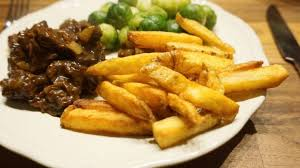

In [146]:
food = "Fries"
num = 0

testing_food = list(test_dir.glob(f"{food}/*"))

print(convert_toarray(testing_food, num))
PIL.Image.open(testing_food[num])

1/1 [==============================] - 0s 16ms/step
На картинке вероятно Crispy Chicken с уверенностью 99.9%)


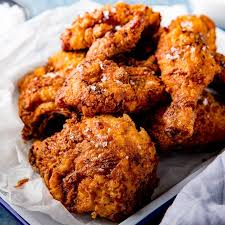

In [147]:
food = "Crispy Chicken"
num = 1

testing_food = list(test_dir.glob(f"{food}/*"))

print(convert_toarray(testing_food, num))
PIL.Image.open(testing_food[num])

1/1 [==============================] - 0s 17ms/step
На картинке вероятно Sandwich с уверенностью 74.28%)


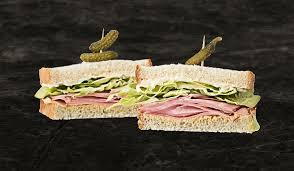

In [155]:
food = "Sandwich"
num = 3

testing_food = list(test_dir.glob(f"{food}/*"))

print(convert_toarray(testing_food, num))
PIL.Image.open(testing_food[num])